In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

E_DOPPIO  = np.load('Error_Matrices/E_DOPPIO.npy')
E_MOCA    = np.load('Error_Matrices/E_MOCA.npy')
E_VGspace = np.load('Error_Matrices/E_VGspace.npy')
R_DOPPIO  = np.load('Error_Matrices/R_DOPPIO.npy')
R_MOCA    = np.load('Error_Matrices/R_MOCA.npy')
R_VGspace = np.load('Error_Matrices/R_VGspace.npy')


In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u_ICE, v_ICE, x, y = calculate_eddy()
X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

u_IEE, v_IEE, *_ = calculate_eddy(q11=2, q22=2, q12=1)

/scratch/pbs.6295708.kman.restech.unsw.edu.au/ipykernel_3452361/246445102.py:22: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, ax=ax, label='Error (km)')
/scratch/pbs.6295708.kman.restech.unsw.edu.au/ipykernel_3452361/246445102.py:39: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, ax=ax, label=labels[i])


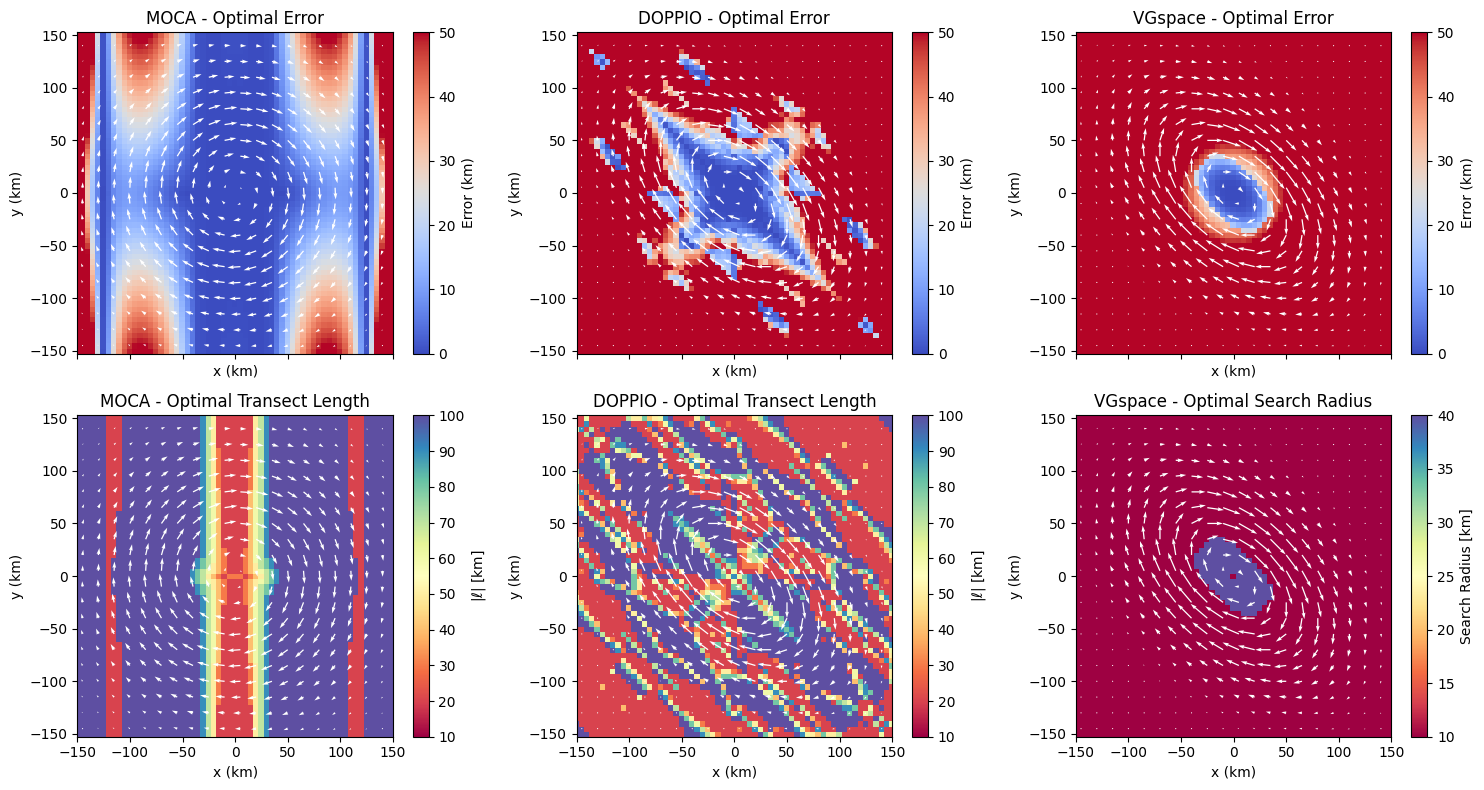

In [63]:
# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)

error_mats = [E_MOCA, E_DOPPIO, E_VGspace]
r_mats     = [2 * R_MOCA * dx, 2 * R_DOPPIO * dx, R_VGspace * dx]
titles_E   = ['MOCA - Optimal Error', 'DOPPIO - Optimal Error', 'VGspace - Optimal Error']
titles_R   = ['MOCA - Optimal Transect Length', 'DOPPIO - Optimal Transect Length', 'VGspace - Optimal Search Radius']

labels = [r'$|\ell|$ [km]', r'$|\ell|$ [km]', 'Search Radius [km]']

# Parameters for the pcolor and quiver plots
vmin, vmax = 0, 50
spacing = 3  # spacing for quiver
width = .004
scale = 50
alpha = 1

# Plot E matrices on the top row
for i, ax in enumerate(axs[0]):
    im = ax.pcolor(X, Y, error_mats[i].T, vmin=vmin, vmax=vmax, cmap='coolwarm')
    # if 'VG' in titles_E[i]:
    fig.colorbar(im, ax=ax, label='Error (km)')
    if 'MOCA' in titles_E[i]:
        ax.quiver(x[::spacing], y[::spacing],
              u_ICE[::spacing, ::spacing].T, v_ICE[::spacing, ::spacing].T,
              alpha=alpha, scale=scale, width=width, color='w')
    else:
        ax.quiver(x[::spacing], y[::spacing],
              u_IEE[::spacing, ::spacing].T, v_IEE[::spacing, ::spacing].T,
              alpha=alpha, scale=scale, width=width, color='w')
    ax.set_title(titles_E[i])
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

# Plot R matrices on the bottom row
for i, ax in enumerate(axs[1]):
    im = ax.pcolor(X, Y, r_mats[i].T, vmin=2*dx, vmax=None, cmap='Spectral')
    # if 'VG' in titles_E[i]:
    fig.colorbar(im, ax=ax, label=labels[i])
    if 'MOCA' in titles_E[i]:
        ax.quiver(x[::spacing], y[::spacing],
              u_ICE[::spacing, ::spacing].T, v_ICE[::spacing, ::spacing].T,
              alpha=alpha, scale=scale, width=width, color='w')
    else:
        ax.quiver(x[::spacing], y[::spacing],
              u_IEE[::spacing, ::spacing].T, v_IEE[::spacing, ::spacing].T,
              alpha=alpha, scale=scale, width=width, color='w')
    ax.set_title(titles_R[i])
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

for ax in axs.flat:

    ax.axis('equal')
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)

plt.tight_layout()
plt.show()